# Meet PyMKS

In this short introduction, we will demonstrate the functionality of PyMKS to compute 2-point statistics in order to objectively quantify microstructures, predict effective properties using homogenization and predict local properties using localization. If you would like more technical details abount any of these methods please see the [theory section](THEORY.html).

In [37]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###Quantify Microstructures using 2-Point Statistics

Lets make two dual-phase microstructures with different morphologies.

In [38]:
from pymks.datasets import make_microstructure

X_1 = make_microstructure(n_samples=1, grain_size=(25, 25))
X_2 = make_microstructure(n_samples=1, grain_size=(15, 95))

X = np.concatenate((X_1, X_2))


Throughout PyMKS `X` is used to represent microstructures. Now that we have made the two microstructures, lets take a look at them.

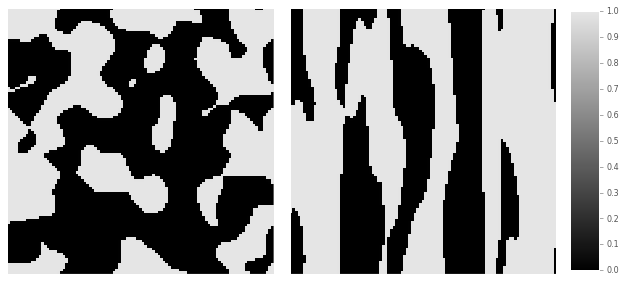

In [39]:
from pymks.tools import draw_microstructures

draw_microstructures(X)


We can compute the 2-point statistics for these two periodic microstructures using the `correlate` function from `pymks.stats`. This function computes all of the autocorrelations and cross-correlation(s) for a microstructure. Before we compute the 2-point statistics, we will discretize them using the `PrimitiveBasis` function.

In [40]:
from pymks import PrimitiveBasis
from pymks.stats import correlate

prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
X_ = prim_basis.discretize(X)
X_corr = correlate(X_, periodic_axes=[0, 1])


Let's take a look at the two autocorrelations and the cross-correlation for these two microstructures.

(101, 101, 3)


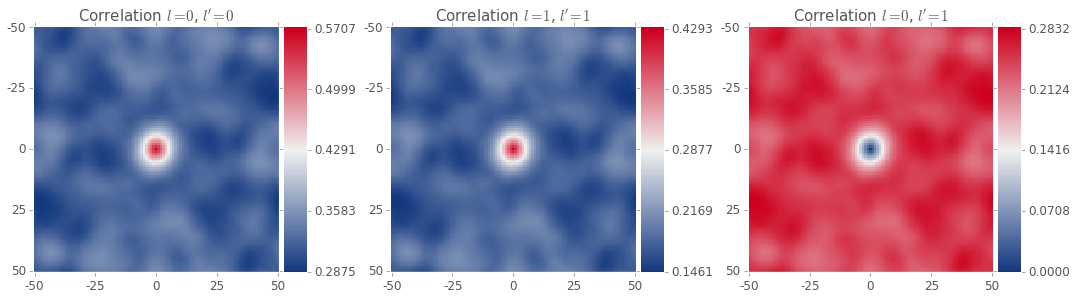

In [41]:
from pymks.tools import draw_correlations

print X_corr[0].shape

draw_correlations(X_corr[0])


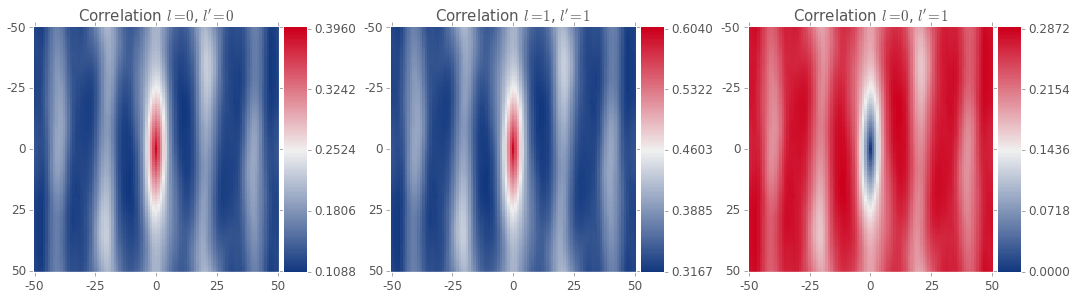

In [42]:
draw_correlations(X_corr[1])


2-Point statistics provide an object way to compare microstructures, and have been shown as an effective input to machine learning methods.

###Predict Homogenized Properties

In this section of the intro, we are going to predict the effective stiffness for two-phase microstructures using the `MKSHomogenizationModel`, but we could have chosen any other effective material property.  

First we need to make some microstructures and their effective stress values to fit our model. Let's create 200 random instances 3 different types of microstructures, totaling to 600 microstructures.

In [43]:
from pymks.datasets import make_elastic_stress_random

grain_size = [(47, 6), (4, 49), (14, 14)]
n_samples = [200, 200, 200]

X_train, y_train = make_elastic_stress_random(n_samples=n_samples, size=(51, 51),
                                              grain_size=grain_size, seed=0)


Once again, `X_train` is our microstructures. Throughout PyMKS `y` is used as either the property, or the field we would like to predict. In this case `y_train` is the effective stress values for `X_train`. Let's look at one of each of the three different types of microstructures.

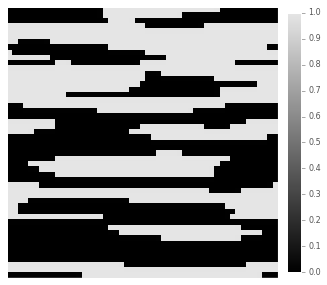

In [51]:
draw_microstructures(X_train[::200])


The `MKSHomogenizationModel` uses 2-point statistics, so we need to provide a discretization method for the microstructures by providing a basis function. We will also specify which correlations we want.

In [64]:
from pymks import MKSHomogenizationModel

prim_basis = PrimitiveBasis(n_states=2, domain=[0, 1])
homogenize_model = MKSHomogenizationModel(basis=prim_basis,
                                          correlations=[(0, 0), (1, 1), (0, 1)])


Let's fit our model with the data we created.

In [65]:
homogenize_model.fit(X_train, y_train, periodic_axes=[0, 1])


Now let's make some new data to see how good our model is.

In [66]:
n_samples = [10, 10, 10]
X_test, y_test = make_elastic_stress_random(n_samples=n_samples, size=(51, 51),
                                            grain_size=grain_size, seed=100)


We will try and predict the effective stress of our `X_test` microstructures.

In [67]:
y_pred = homogenize_model.predict(X_test, periodic_axes=[0, 1])


The `MKSHomogenizationModel` generates low dimensional representations of microstructures and regression methods to predict effective properties. Take a look at the low-dimensional representations.

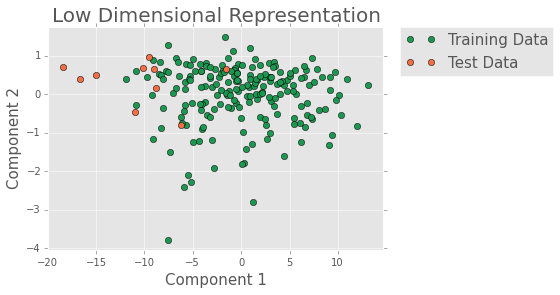

In [74]:
from pymks.tools import draw_components_scatter
draw_components_scatter([homogenize_model.reduced_fit_data[:,:2], homogenize_model.reduced_predict_data[:,:2]], 
                        ['Training Data', 'Test Data'])

Now let's look at a goodness of fit plot for our `MKSHomogenizationModel`.

In [ ]:
from pymks.tools import draw_goodness_of_fit

fit_data = np.array([y_train, 
                     homogenize_model.predict(X_train, periodic_axes=[0, 1])])
pred_data = np.array([y_test, y_pred])

draw_goodness_of_fit(fit_data, pred_data, ['Training Data', 'Test Data'])


Looks good.

The `MKSHomogenizationModel` can be used to predict effective properties and processing-structure evolutions.

###Predict Local Properties

In this section of the intro, we are going to predict the local strain field in a microstructure using `MKSLocalizationModel`, but we could have predicted another local property.

First we need some data, so let's make some.

In [ ]:
from pymks.datasets import make_elastic_FE_strain_delta

X_delta, y_delta = make_elastic_FE_strain_delta()


Once again, `X_delta` is our microstructures and `y_delta` is our local strain fields. We need to discretize the microstructure again, so we will also use the same basis function.

In [ ]:
from pymks import MKSLocalizationModel

prim_basis = PrimitiveBasis(n_states=2)
localize_model = MKSLocalizationModel(basis=prim_basis)


Let's use the data to fit our `MKSLocalizationModel`.

In [ ]:
localize_model.fit(X_delta, y_delta)


Now that we have fit our model, we will create a random microstructure and compute its local strain field, using finite element analysis. We will then try and reproduce the same strain field with our model.

In [ ]:
from pymks.datasets import make_elastic_FE_strain_random

X_test, y_test = make_elastic_FE_strain_random()


Let's look at the microstructure and its local strain field.

In [ ]:
from pymks.tools import draw_microstructure_strain

draw_microstructure_strain(X_test[0], y_test[0])


Now let's pass that same microstructure to our `MKSLocalizationModel` and compare the predicted and computed local strain field.

In [ ]:
from pymks.tools import draw_strains_compare


y_pred = localize_model.predict(X_test)
draw_strains_compare(y_test[0], y_pred[0])


Not bad.

The `MKSLocalizationModel` can be used to predict local properties and local processing-structure evolutions.